In [9]:
%%capture
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor ,AdaBoostRegressor
import itertools as it
import time as time
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from pyearth import Earth
import warnings
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time
from pyearth import Earth
from sklearn.model_selection import RandomizedSearchCV, KFold

## Data quality check / cleaning / preparation 

### Data cleaning
*By Anastasia Wei*

In [6]:
# read in the red and white wine files
red = pd.read_csv('../Data/winequality-red.csv', delimiter = ";")
white = pd.read_csv('../Data/winequality-white.csv', delimiter = ";")
red['type'] = 'red'
white['type'] = 'white'

# combine the red and white wine data
all_df = pd.concat([red, white], ignore_index = True)
all_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


### Distribution of response
*By Anastasia Wei*

In [7]:
# Mean and standard deviation of response
print('Response mean =', np.average(all_df.quality))
print('Response standard deviation =', np.std(all_df.quality))

Response mean = 5.818377712790519
Response standard deviation = 0.8731880644450432


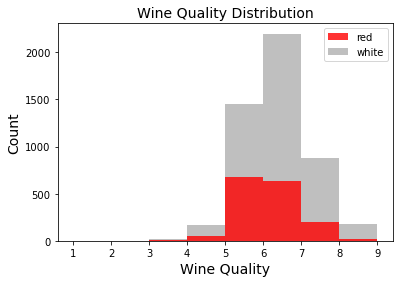

In [8]:
# response distribution
plt.hist(red.quality.values, bins = np.arange(1,10), color = 'r', alpha = 0.8, zorder = 5,  label = 'red')
plt.title('Wine Quality Distribution', fontsize=14)
plt.hist(white.quality.values, bins = np.arange(1,10), color = 'grey', alpha = 0.5, label = 'white')
plt.legend()
plt.xlabel('Wine Quality', fontsize=14)
plt.ylabel('Count', fontsize=14);

### Data preparation
*By Amy Wang*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Creating dummy variables for `type`, a categorical variable describing the type of wine, so that the predictors are all numerical.
2. Scaling the predictors so that they are all equally weighted by models we fit.
3. Splitting into test and train data.

In [10]:
#####------Splitting the predictors and response variable-----#####
X = all_df.drop("quality", axis = 1)
y = all_df.quality

In [11]:
######---------------Creating dummy variables for type ----------------#########
X_dummy = pd.get_dummies(X)
X_dummy.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0


In [13]:
#####-----Scaling the predictors-----#####

# There is a large difference in the range of the predictors, justifying a need to scale.
X_dummy.max() - X_dummy.min()

fixed acidity            12.10000
volatile acidity          1.50000
citric acid               1.66000
residual sugar           65.20000
chlorides                 0.60200
free sulfur dioxide     288.00000
total sulfur dioxide    434.00000
density                   0.05187
pH                        1.29000
sulphates                 1.78000
alcohol                   6.90000
type_red                  1.00000
type_white                1.00000
dtype: float64

We choose to use MinMaxScaler to scale the predictors. StandardScaler assumes that the distribution of the predictors are normal. From the QQ plots of the first three predictors, this assumption does not hold all predictors (a normally distributed predictor would have its values align closely with the 45 degree line). 

"MinMaxScaler scales the data to a fixed range, typically between 0 and 1. On the other hand, StandardScaler rescales the data to have a mean of 0 and a standard deviation of 1. This results in a distribution with zero mean and unit variance." - [Source](https://vitalflux.com/minmaxscaler-standardscaler-python-examples/#:~:text=Differences%20between%20MinMaxScaler%20and%20StandardScaler,-Both%20MinMaxScaler%20and&text=MinMaxScaler%20scales%20the%20data%20to,zero%20mean%20and%20unit%20variance.)

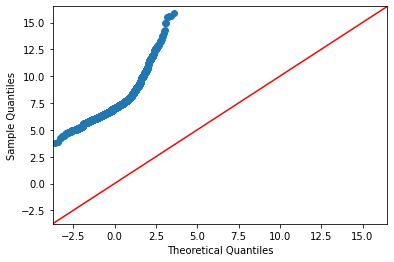

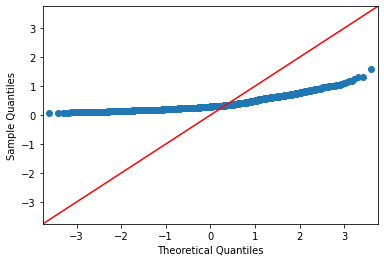

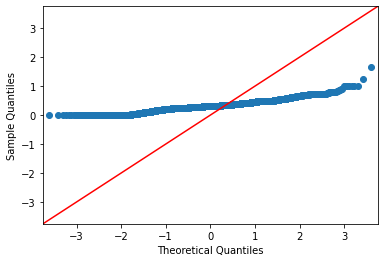

In [14]:
np.random.seed(1)

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(X_dummy.iloc[:,0], line='45')
fig2 = sm.qqplot(X_dummy.iloc[:,1], line='45')
fig3 = sm.qqplot(X_dummy.iloc[:,2], line='45')

plt.show()

In [15]:
scaler = MinMaxScaler()

X_dummy_sca = pd.DataFrame(scaler.fit_transform(X_dummy), columns = X_dummy.columns)
X_dummy_sca.head()

X_train, X_test, y_train, y_test = train_test_split(X_dummy_sca, y, test_size = 0.2, random_state = 45)

## Exploratory data analysis
*By Kaitlyn Hung*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Intercept Base Model
*By Anastasia Wei*

In [ ]:
# predicting the response as the mean of the train response 
pred = [np.around(np.mean(y_train))]*len(y_test)

In [ ]:
# test RMSE
np.sqrt(mean_squared_error(y_test, pred))

0.9327379053088815

### Ridge and Lasso Regression
*By Anastasia Wei*

In [ ]:
### Ridge Regression
# defining regulization parameter space
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', store_cv_values = True)
ridgecv.fit(X_train, y_train)
print("Optimal alpha = ", ridgecv.alpha_)

# using the developed ridge regression model to predict on test & train data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)

print('Train RMSE = ', np.sqrt(mean_squared_error(y_train, np.around(ridge.predict(X_train)))))
print('Test RMSE = ', np.sqrt(mean_squared_error(y_test, np.around(pred))))

Optimal alpha =  0.01636987568069109
Train RMSE =  0.7892143827427598
Test RMSE =  0.8166535844059444


In [16]:
#### Lasso Regression
# Searching through regularizatio parameter space 
alphas = 10**np.linspace(2,-5,200)*0.5
rmses = []
for a in alphas:
    lasso = Lasso(alpha = a)
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, np.around(pred)))
    rmses.append(rmse)

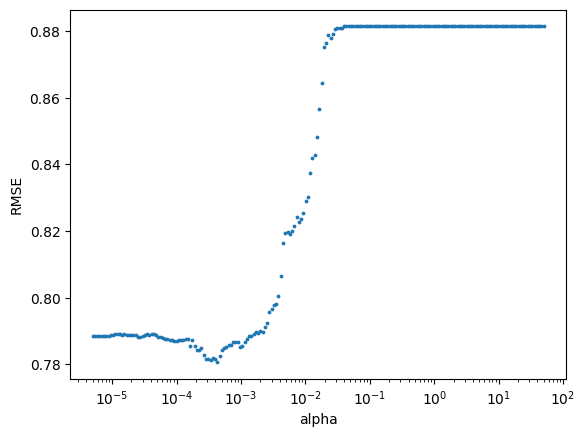

In [17]:
# Visualizing rmse vs alpha
plt.scatter(alphas, rmses, s = 3)
plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.xscale('log')

In [18]:
print('Optimal alpha =', alphas[np.array(rmses).argmin()])
print('Optimal train RMSE = ', rmses[np.array(rmses).argmin()])

Optimal alpha = 0.0004301732208342255
Optimal train RMSE =  0.7806343783815696


In [21]:
lasso = Lasso(alpha = 0.0004301732208342255)
pred = lasso.fit(X_train, y_train).predict(X_test)
print('Test RMSE = ', np.sqrt(mean_squared_error(y_test, np.around(pred))))

Test RMSE =  0.8138228875545909


### MARS
*By Lila Wells*

Beginning with the original coarse grid search (optimizing `max_depth` and `max_degree` simultaneously in a nested for loop)

In [17]:
# Coarse grid search for hyperparameter optimization
    # Note: I fit 25 models here and it took approximately an hour and a half (90 mins)

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)
init_search_df = pd.DataFrame(columns = ['degree', 'max_terms', 'rmse'])


# Lists to store the values for plotting
degrees = []
max_terms_values = []
mean_scores = []

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in range(1, 11, 2):
    # print('Fitting models for degree = ', degree)

    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(400, 1201, 200):
        # print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_root_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Saving the values for plotting
        degrees.append(degree)
        max_terms_values.append(terms)
        mean_scores.append(mean_score)
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms

# Printing the optimal hyperparameters
print('Optimal max_terms in coarse grid search = ', opt_max_terms)
print('Optimal max_degree in coarse grid search = ', opt_degree)    


Optimal max_terms in coarse grid search =  400
Optimal max_degree in coarse grid search =  5


In [18]:
### Defining the initial MARS model and making predictions on test data to compute RMSE

# Defining the MARS model
mars_init = Earth(max_terms = 400, max_degree = 5).fit(X_train, y_train)

# Making predictions & rounding them to the nearest integer 
pred_mars_init = np.around(mars_init.predict(X_test))

# Printing the coarse grid RMSE 
print("Coarse Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, pred_mars_init)))

Coarse Grid Tuning MARS Model Test RMSE: 1.5657389506359167


Attempting to further optimize the MARS model with a finer grid search over a narrower range of hyperparameters (4-7 for `max_degree` and 300-800 for `max_terms`).

In [20]:
# Finer grid search
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning) # Got 7 and 800

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in [4, 5, 6, 7]: 
    # print('Fitting models for degree = ', degree)
    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(300, 801, 100): 
        # print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_root_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms
            
print("Optimal degree in fine grid search = ", degree)
print("Optimal max_terms in fine grid search = ", terms)

Optimal degree in fine grid search =  7
Optimal max_terms in fine grid search =  800


In [21]:
### Defining the final MARS model and making predictions on test data to compute RMSE

# Defining the MARS model
mars_final = Earth(max_terms = 800, max_degree = 7).fit(X_train, y_train)

# Making predictions & rounding them to the nearest integer 
pred_mars_final = np.around(mars_final.predict(X_test))

# Printing the coarse grid RMSE 
print("Fine Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, pred_mars_final)))

Fine Grid Tuning MARS Model Test RMSE: 0.790326125479466


The next step here was to predict the model's train data residuals, and build a model to predict those residuals (in an effort to improve the MARS model).

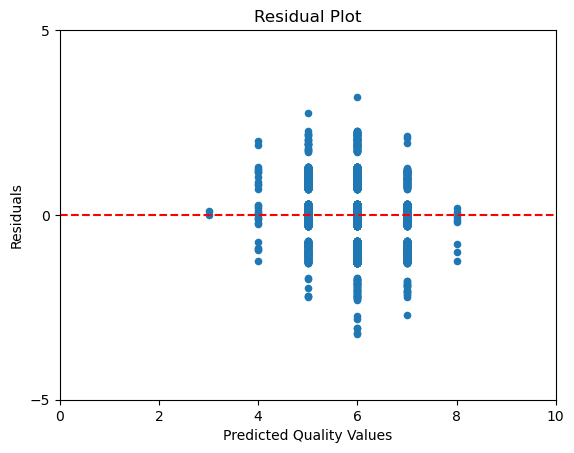

In [27]:
# Making predictions with the optimized MARS model 
prediction_mars = np.around(mars_final.predict(X_train)) # Rounding them to the nearest integer 

# Converting the predictions to a dataframe 
prediction_mars = pd.Series(prediction_mars, name='quality')
prediction_mars = prediction_mars.to_frame().rename(columns={'quality': 'quality'})

# Calculate residuals
residuals = y_train - prediction_mars

# Plotting residuals 
df = pd.concat([prediction_mars, residuals], axis=1)
df.columns = ['quality', 'residuals']

# Jittering the points
jitter_amount = 0.3
df['jittered_residuals'] = df['residuals'] + np.random.uniform(low=-jitter_amount, high=jitter_amount, size=len(df))

# Plotting the points
residual_mars_plt = df.plot(x='quality', y='jittered_residuals', kind='scatter')
residual_mars_plt.axhline(y=0, color='red', linestyle='--')  # Add line y = 0
residual_mars_plt.set_xlabel('Predicted Quality Values')
residual_mars_plt.set_ylabel('Residuals')
residual_mars_plt.set_title('Residual Plot')
residual_mars_plt.set_xlim([0, 10])
residual_mars_plt.set_ylim([-5, 5])
residual_mars_plt.set_yticks([-5, 0, 5])


Now creating a model to predict residuals of the MARS model.

In [30]:
# Fitting a MARS model to predict residuals
residual_model = Earth()
residual_model.fit(prediction_mars, residuals)

# Make predictions on test set
residuals_pred = residual_model.predict(pred_mars_final) # These predictions are the MARS test predictions

Adding the residual predictions to the test 

In [33]:
# Making predictions with the residuals model
# Rounding predictions to the nearest integer 
residuals_pred = np.around(residual_model.predict(pred_mars_final))
residuals_pred_series = pd.Series(residuals_pred, name='quality') # Making residuals into a series
pred_mars_final = pd.Series(pred_mars_final, name='quality') # Turning the test predictions into a Series

# Add predicted residuals to y_pred to get final predictions
y_pred_final = pd.concat([pred_mars_final, residuals_pred_series], axis=1).sum(axis=1)

# Calculating the final MARS model RMSE 
print("Test RMSE of Fine Grid MARS Model & Residuals Model:", np.sqrt(mean_squared_error(y_test, y_pred_final)))

Test RMSE of Fine Grid MARS Model & Residuals Model: 0.7775701798650618


### Decision Tree
*By Kaitlyn Hung*

### Bagging Decision Tree
*By Lila Wells*

First, identifying the optimal number of trees to use by visualizing the number of trees vs. R-squared

In [19]:
# Finding model accuracy vs number of trees
oob_rsquared = {}; test_rsquared = {}; oob_rmse = {}; test_rmse = {}

# Iterating over tree values 
for i in range(100, 1201, 50):
    model = BaggingRegressor(base_estimator = DecisionTreeRegressor(random_state = 1), 
                             n_estimators = i, 
                             random_state = 1,
                             n_jobs=-1,
                             oob_score = True).fit(X_train, y_train)

    oob_rsquared[i] = model.oob_score_  # Returns the out-of_bag R-squared of the model
    test_rsquared[i] = model.score(X_test, y_test) # Returns the test R-squared of the model
    oob_rmse[i] = np.sqrt(mean_squared_error(model.oob_prediction_, y_train))
    test_rmse[i] = np.sqrt(mean_squared_error(model.predict(X_test), y_test))

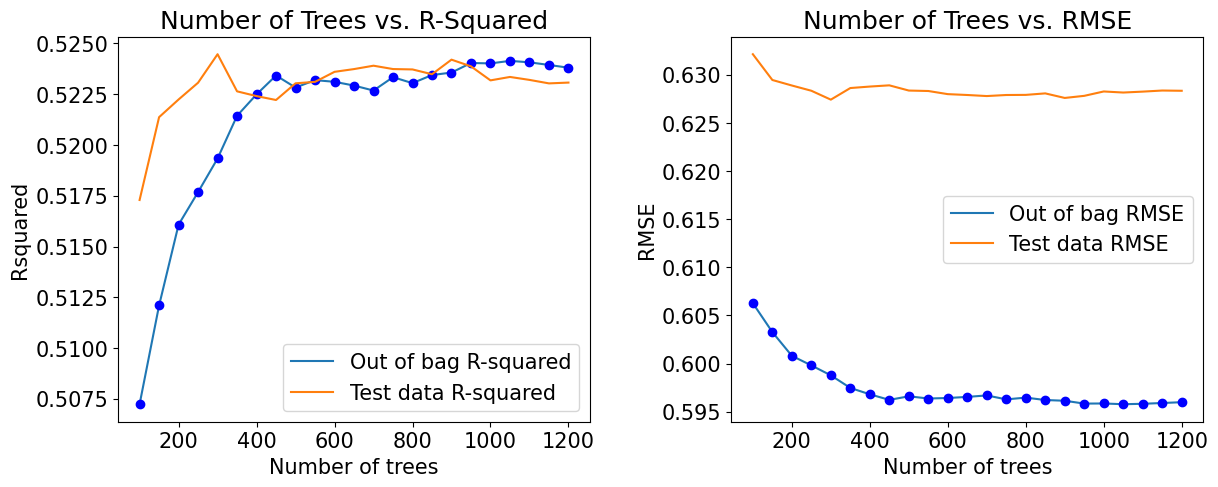

In [32]:
# Plotting results
fig, axes = plt.subplots(1,2,figsize=(14,5))

plt.subplots_adjust(wspace= 0.3)
axes[0].plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
axes[0].plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
axes[0].plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
axes[0].set_title('Number of Trees vs. R-Squared')
axes[0].set_xlabel('Number of trees')
axes[0].set_ylabel('Rsquared')
axes[0].legend()
axes[1].plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
axes[1].plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
axes[1].plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
axes[1].set_title('Number of Trees vs. RMSE')
axes[1].set_xlabel('Number of trees')
axes[1].set_ylabel('RMSE')
axes[1].legend()


From this, it looks like any number of trees past 500 seems to stabilize the test RMSE.

In [41]:
import warnings 
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)

# Optimizing hyperparameters
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

params = {'estimator': [DecisionTreeRegressor(random_state = 1)],
          'n_estimators': range(500, 1001, 100),
          'max_samples': [0.5, 0.75, 1.0],
          'max_features': [0.5, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

# 2-fold cross validation to minimize runtime
cv = KFold(n_splits = 2, shuffle = True, random_state = 1)

bagging_grid = GridSearchCV(BaggingRegressor(random_state = 1, n_jobs = -1),
                            param_grid = params,
                            cv = cv, 
                            scoring = "neg_root_mean_squared_error",
                            n_jobs = -1,
                            verbose = 1)


bagging_grid.fit(X_train, y_train.values.ravel())

print('Best Score Through Grid Search : %.3f'%bagging_grid.best_score_)
print('Best Parameters : ', bagging_grid.best_params_)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
Best R^2 Score Through Grid Search : -0.639
Best Parameters :  {'bootstrap': False, 'bootstrap_features': True, 'estimator': DecisionTreeRegressor(random_state=1), 'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 1000}


Visualizing the results of the hyperparameter search

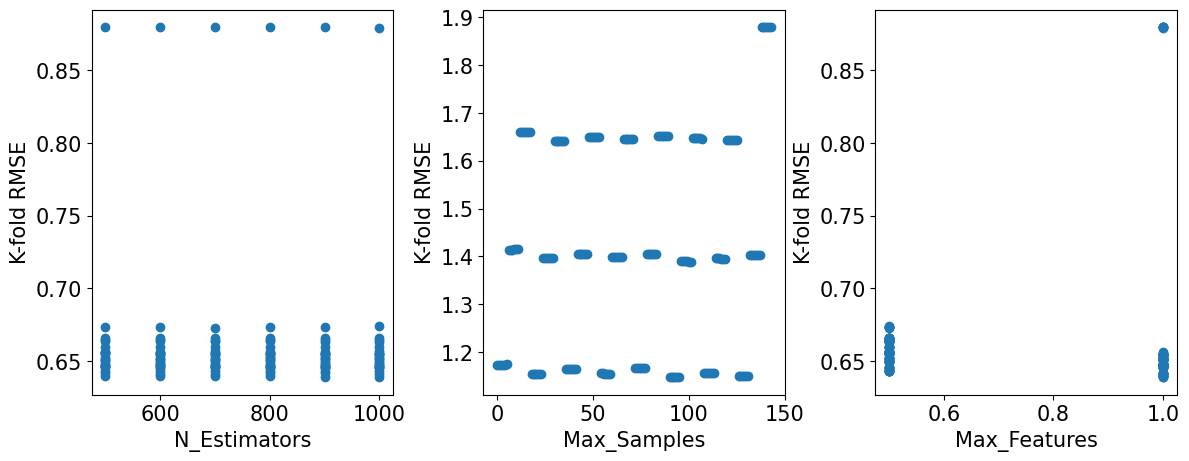

In [42]:
# Plotting results
cv_results = pd.DataFrame(bagging_grid.cv_results_)
fig, axes = plt.subplots(1,3,figsize=(14,5))

plt.subplots_adjust(wspace= 0.3)
axes[0].plot(cv_results.param_n_estimators, -cv_results.mean_test_score, 'o')
axes[0].set_xlabel('N_Estimators')
axes[0].set_ylabel('K-fold RMSE') 
axes[1].plot(cv_results.param_max_samples -cv_results.mean_test_score, 'o')
axes[1].set_xlabel('Max_Samples')
axes[1].set_ylabel('K-fold RMSE');
axes[2].plot(cv_results.param_max_features, -cv_results.mean_test_score, 'o')
axes[2].set_xlabel('Max_Features')
axes[2].set_ylabel('K-fold RMSE');

Defining the initial base model.

In [3]:
# Defining the initial base model 
bagging_init = BaggingRegressor(random_state = 1, 
                                 n_jobs = -1,
                                 estimator = DecisionTreeRegressor(random_state = 1),
                                 n_estimators = 900, 
                                 max_samples = 0.75, 
                                 max_features = 1.0,
                                 bootstrap_features = True, 
                                 bootstrap = False)
bagging_init.fit(X_train, y_train)

/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(bootstrap=False, bootstrap_features=True,
                 estimator=DecisionTreeRegressor(random_state=1),
                 max_samples=0.75, n_estimators=900, n_jobs=-1, random_state=1)

Then, making predictions on test data to identify the test RMSE of this bagging model (optimized via a coarse grid search of hyperparameters).

In [4]:
# Making predictions
pred_init = np.around(bagging_init.predict(X_test)) # Rounding predictions to the nearest integer 

# Printing the test RMSE of the coarse grid tuning model
print("Coarse Grid Tuning Bagging Model Test RMSE:", np.sqrt(mean_squared_error(y_test, pred_init)))

Coarse Grid Tuning Bagging Model Test RMSE: 0.6673714223613529


Now, implementing a finer grid search of hyperparameters in an attempt to lower the bagging model's RMSE.

In [10]:

# Finer grid search
import warnings 
warnings.filterwarnings("ignore")
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Optimizing hyperparameters
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

params = {'estimator': [DecisionTreeRegressor(random_state = 1)],
          'n_estimators': range(800, 1101, 60), # Narrowing this search space based on coarse grid results 
          'max_samples': [0.6, 0.75, 0.9], # Narrowing this search space based on coarse grid results
          'max_features': [0.5, 0.75, 0.85, 1.0], # Lowering this search space based on coarse grid resutlss
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

# 2-fold cross validation to minimize runtime
cv = KFold(n_splits = 2, shuffle = True, random_state = 1)

# Using GridSearchCV here 
bagging_grid = GridSearchCV(BaggingRegressor(random_state = 1, n_jobs = -1),
                            param_grid = params,
                            cv = cv, 
                            scoring = "neg_mean_squared_error",
                            n_jobs = -1, 
                            verbose = 1)

# Fitting the bagging model 
bagging_grid.fit(X_train, y_train.values.ravel())

Fitting 2 folds for each of 288 candidates, totalling 576 fits
Best Score Through Grid Search : -0.407
Best Parameters :  {'bootstrap': False, 'bootstrap_features': False, 'estimator': DecisionTreeRegressor(random_state=1), 'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 1040}


In [13]:
# Printing the best score and parameters
print('Best Score Through Grid Search : %.3f'%bagging_grid.best_score_)
print('Best Parameters : ', bagging_grid.best_params_)

Best Score Through Grid Search : -0.407
Best Parameters :  {'bootstrap': False, 'bootstrap_features': False, 'estimator': DecisionTreeRegressor(random_state=1), 'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 1040}


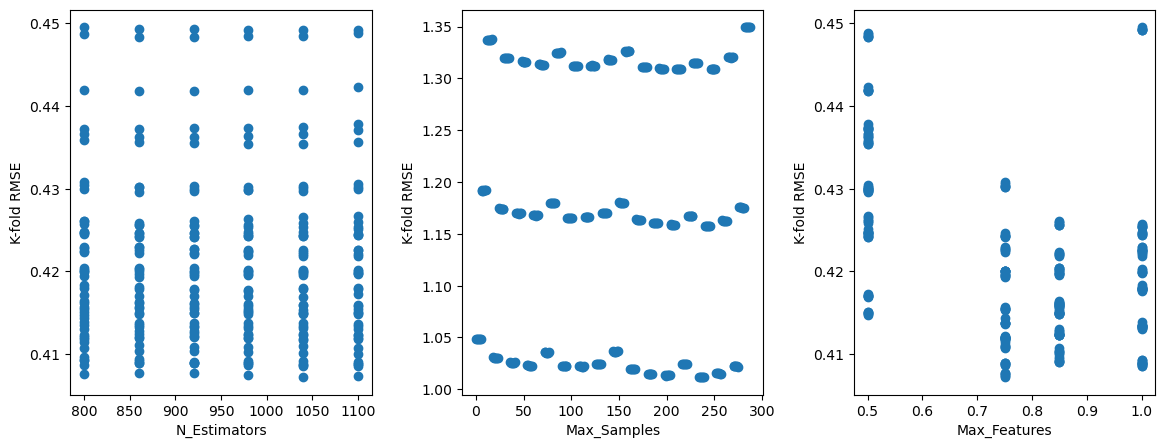

In [12]:
# Plotting results
cv_results = pd.DataFrame(bagging_grid.cv_results_)
fig, axes = plt.subplots(1,3,figsize=(14,5))

plt.subplots_adjust(wspace= 0.3)
axes[0].plot(cv_results.param_n_estimators, -cv_results.mean_test_score, 'o')
axes[0].set_xlabel('N_Estimators')
axes[0].set_ylabel('K-fold RMSE') 
axes[1].plot(cv_results.param_max_samples -cv_results.mean_test_score, 'o')
axes[1].set_xlabel('Max_Samples')
axes[1].set_ylabel('K-fold RMSE');
axes[2].plot(cv_results.param_max_features, -cv_results.mean_test_score, 'o')
axes[2].set_xlabel('Max_Features')
axes[2].set_ylabel('K-fold RMSE');

In [14]:
# Defining the optimized base model 
bagging_opt = BaggingRegressor(random_state = 1, 
                                n_jobs = -1,
                                estimator = DecisionTreeRegressor(random_state = 1),
                                n_estimators = 1040, 
                                max_samples = 0.75, 
                                max_features = 0.75,
                                bootstrap_features = False, 
                                bootstrap = False)
                                
bagging_opt.fit(X_train, y_train)

BaggingRegressor(bootstrap=False,
                 estimator=DecisionTreeRegressor(random_state=1),
                 max_features=0.75, max_samples=0.75, n_estimators=1040,
                 n_jobs=-1, random_state=1)

In [15]:
# Making predictions
rounded_pred_opt = np.around(bagging_opt.predict(X_test)) # Rounding predictions to the nearest integer 

# Printing the test RMSE of the coarse grid tuning model
print("Fine Grid Tuning Bagging Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred_opt)))

Fine Grid Tuning Bagging Model Test RMSE: 0.665640235470275


### Random Forest
*By Amy Wang*

### AdaBoost
*By Kaitlyn Hung*

### Gradient Boosting
*By Anastasia Wei*

>5 0.793 (0.021)
>10 0.753 (0.020)
>50 0.694 (0.014)
>100 0.680 (0.013)
>500 0.662 (0.010)
>1000 0.660 (0.009)
>1500 0.660 (0.008)
>2000 0.662 (0.007)
>2500 0.662 (0.009)


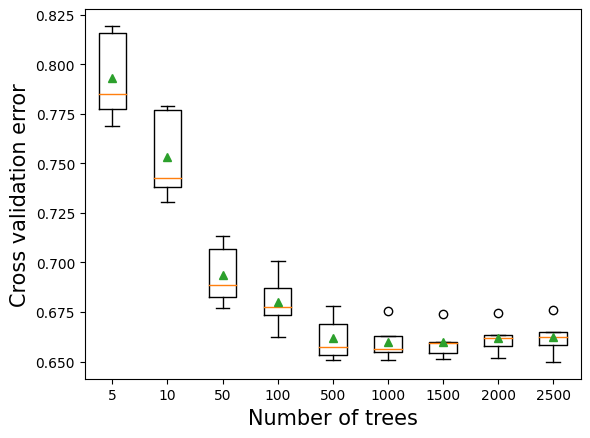

In [3]:
# define the range of n_estimators
def get_models():
    models = dict()
    n_trees = [5, 10, 50, 100, 500, 1000, 1500, 2000, 2500]
    for n in n_trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n,random_state=1,loss='huber')
    return models

# evaluate the model using cross-validation
def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels= names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15);

In [6]:
# 4 fold cv coarse grid search based on previous search
start_time = time.time()
model = GradientBoostingRegressor(random_state = 1, loss='huber')
grid = dict()
grid['n_estimators'] = [1200, 1400, 1600, 1800]
grid['learning_rate'] = [0.1, 0.2, 0.3]
grid['max_depth'] = [8, 10, 12, 14]
grid['subsample'] = [0.4, 0.6, 0.8, 1]

cv = KFold(n_splits = 4, shuffle=True, random_state=1)
grid_search = RandomizedSearchCV(estimator = model, 
                                 param_distributions = grid, 
                                 n_jobs = -1, cv = cv, 
                                 n_iter = 50,
                                 scoring = 'neg_mean_squared_error',
                                 verbose = True)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))

print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best: 0.623735 using {'subsample': 0.8, 'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.1}
Time taken =  24.304628153642017  minutes


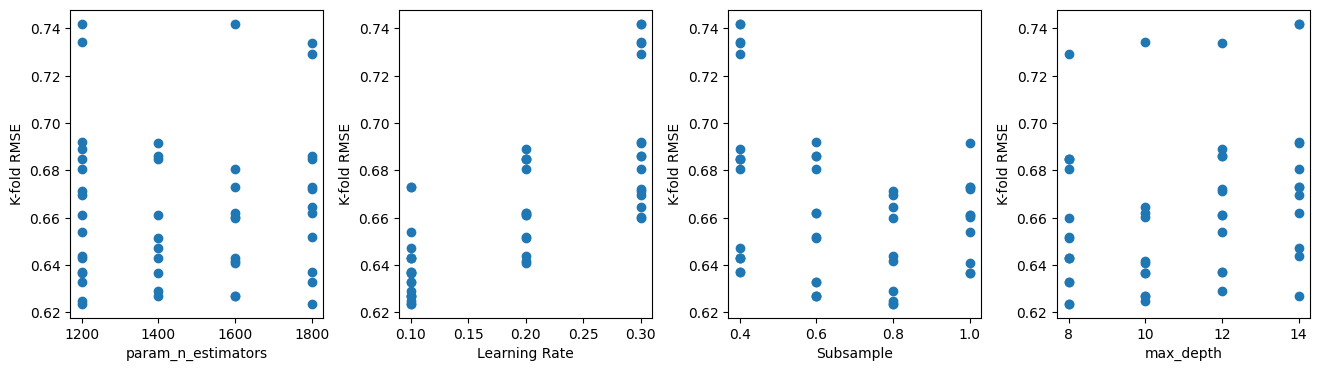

In [8]:
# visualize cv results
cv_results = pd.DataFrame(grid_result.cv_results_)

fig, axes = plt.subplots(1, 4, figsize = (16, 4))
plt.subplots_adjust(wspace = 0.3)
axes[0].plot(cv_results.param_n_estimators, np.sqrt(-cv_results.mean_test_score), 'o')
axes[0].set_xlabel('param_n_estimators')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_learning_rate, np.sqrt(-cv_results.mean_test_score), 'o')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('K-fold RMSE')
axes[2].plot(cv_results.param_subsample, np.sqrt(-cv_results.mean_test_score), 'o')
axes[2].set_xlabel('Subsample')
axes[2].set_ylabel('K-fold RMSE');
axes[3].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_score), 'o')
axes[3].set_xlabel('max_depth')
axes[3].set_ylabel('K-fold RMSE');

In [11]:
# computing train and test rmse based on initial optimization
model = GradientBoostingRegressor(n_estimators = 1200, loss = 'huber', max_depth = 8, 
                                  learning_rate = 0.1, subsample = 0.8, 
                                  random_state = 45).fit(X_train,y_train)
pred = model.predict(X_test)
print('The test RMSE is', np.sqrt(mean_squared_error(y_test, np.around(pred))))

The test RMSE is 0.6782329983125268


In [12]:
# computing train and test rmse based on initial optimization
model = GradientBoostingRegressor(n_estimators = 1400, loss = 'huber', max_depth = 8, 
                                  learning_rate = 0.1, subsample = 0.8, 
                                  random_state = 45).fit(X_train,y_train)
pred = model.predict(X_test)
print('The test RMSE is', np.sqrt(mean_squared_error(y_test, np.around(pred))))

The test RMSE is 0.6776656765919086


In [13]:
# finer grid search based on previous optimization
start_time = time.time()
model = GradientBoostingRegressor(random_state = 1, loss='huber')
grid = dict()
grid['n_estimators'] = [1300, 1350, 1400, 1450, 1500]
grid['learning_rate'] = [0.8, 0.1, 0.15]
grid['max_depth'] = [8, 9, 10]
grid['subsample'] = [0.7, 0.8, 0.9, 1]

cv = KFold(n_splits = 4, shuffle=True, random_state=1)
grid_search = RandomizedSearchCV(estimator = model, 
                                 param_distributions = grid, 
                                 n_jobs = -1, cv = cv, 
                                 n_iter = 50,
                                 scoring = 'neg_mean_squared_error',
                                 verbose = True)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))

print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best: 0.620413 using {'subsample': 0.8, 'n_estimators': 1300, 'max_depth': 9, 'learning_rate': 0.1}
Time taken =  18.446675260861713  minutes


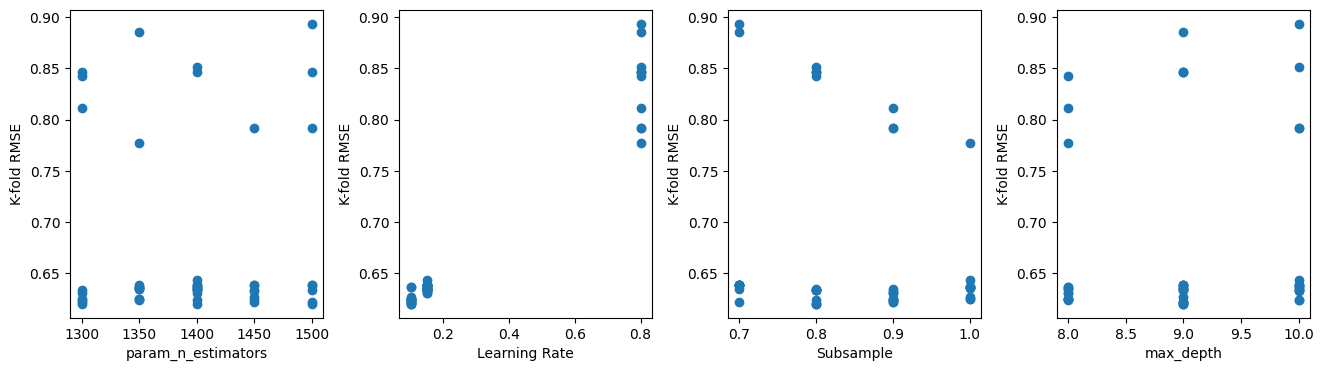

In [14]:
# visualize finer grid search results
cv_results = pd.DataFrame(grid_result.cv_results_)

fig, axes = plt.subplots(1, 4, figsize = (16, 4))
plt.subplots_adjust(wspace = 0.3)
axes[0].plot(cv_results.param_n_estimators, np.sqrt(-cv_results.mean_test_score), 'o')
axes[0].set_xlabel('param_n_estimators')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_learning_rate, np.sqrt(-cv_results.mean_test_score), 'o')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('K-fold RMSE')
axes[2].plot(cv_results.param_subsample, np.sqrt(-cv_results.mean_test_score), 'o')
axes[2].set_xlabel('Subsample')
axes[2].set_ylabel('K-fold RMSE');
axes[3].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_score), 'o')
axes[3].set_xlabel('max_depth')
axes[3].set_ylabel('K-fold RMSE');

In [15]:
# model with optimized parameter
model = GradientBoostingRegressor(n_estimators = 1300, loss = 'huber', max_depth = 9, 
                                  learning_rate = 0.1, subsample = 0.8, 
                                  random_state = 1).fit(X_train, y_train)
pred = model.predict(X_test)
# rounded rmse
print('The test RMSE is', np.sqrt(mean_squared_error(y_test, np.around(pred))))

The test RMSE is 0.6713934992009014


Manual Tunning & Testing

In [22]:
# best model
model = GradientBoostingRegressor(n_estimators = 1300, loss = 'huber', max_depth = 9, 
                                  learning_rate = 0.08, subsample = 0.85, 
                                  random_state = 1).fit(X_train, y_train)
pred = model.predict(X_test)

# rounded rmse
print('The test RMSE is', np.sqrt(mean_squared_error(y_test, np.around(pred))))

The test RMSE is 0.6586699885725429


In [23]:
# feature importance
features_df = pd.DataFrame(zip(X_train.columns, list(model.feature_importances_)),
                           columns =['Predictor', 'Importance'])
features_df.sort_values(by = 'Importance', ascending = False)

,Predictor,Importance
10,alcohol,0.250846
1,volatile acidity,0.124307
5,free sulfur dioxide,0.080374
9,sulphates,0.078176
6,total sulfur dioxide,0.077565
3,residual sugar,0.072411
8,pH,0.069419
4,chlorides,0.067845
7,density,0.066263
2,citric acid,0.058864


Other attemps

In [24]:
model = GradientBoostingRegressor(n_estimators = 1300, loss = 'huber', max_depth = 7, 
                                  learning_rate = 0.08, subsample = 0.85, 
                                  random_state = 1).fit(X_train, y_train)
pred = model.predict(X_test)

# rounded rmse
print('The test RMSE is', np.sqrt(mean_squared_error(y_test, np.around(pred))))

The test RMSE is 0.6713934992009014


In [25]:
model = GradientBoostingRegressor(n_estimators = 1400, loss = 'huber', max_depth = 9, 
                                  learning_rate = 0.07, subsample = 0.8, 
                                  random_state = 1).fit(X_train, y_train)
pred = model.predict(X_test)

# rounded rmse
print('The test RMSE is', np.sqrt(mean_squared_error(y_test, np.around(pred))))

The test RMSE is 0.6719661163618754


### CatBoost, and LightGBM
*By Anastasia Wei*

In [26]:
# untuned catboost model with default parameters
model_cat = CatBoostRegressor(verbose = False).fit(X_train, y_train)
print('Train RMSE =', np.sqrt(mean_squared_error(np.around(model_cat.predict(X_train)),y_train)))
print('Test RMSE =', np.sqrt(mean_squared_error(np.around(model_cat.predict(X_test)),y_test)))

Train RMSE = 0.4760979229626765
Test RMSE = 0.7130648907789097


In [27]:
# untuned LGBM model with default parameters
model_lgbm = LGBMRegressor().fit(X_train, y_train)
print('Train RMSE =', np.sqrt(mean_squared_error(np.around(model_lgbm.predict(X_train)),y_train)))
print('Test RMSE =', np.sqrt(mean_squared_error(np.around(model_lgbm.predict(X_test)),y_test)))

Train RMSE = 0.5210592961182009
Test RMSE = 0.7258946734362203


## Model Ensemble 
*By Anastasia Wei*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


Loading and predicting using each of the individual models from previous model section

In [28]:
model_lasso = Lasso(alpha = 0.00036584035717135963).fit(X_train, y_train)
lasso_pred_train = model_lasso.predict(X_train)
lasso_pred_test = model_lasso.predict(X_test)
print("lasso train RMSE =", np.sqrt(mean_squared_error(y_train, np.around(lasso_pred_train))))
print("lasso test RMSE =", np.sqrt(mean_squared_error(y_test, np.around(lasso_pred_test))))

lasso train RMSE = 0.7818658578951756
lasso test RMSE = 0.808131748588634


In [29]:
model_ridge = Ridge(alpha = 0.01636987568069109).fit(X_train, y_train)
ridge_pred_train = model_ridge.predict(X_train)
ridge_pred_test = model_ridge.predict(X_test)
print("ridge train RMSE =", np.sqrt(mean_squared_error(y_train, np.around(ridge_pred_train))))
print("ridge test RMSE =", np.sqrt(mean_squared_error(y_test, np.around(ridge_pred_test))))

ridge train RMSE = 0.7892143827427598
ridge test RMSE = 0.8166535844059444


In [30]:
model_gb = GradientBoostingRegressor(n_estimators = 1300, loss = 'huber', max_depth = 9, 
                                     learning_rate = 0.08, subsample = 0.85, 
                                     random_state = 1).fit(X_train, y_train)
gb_pred_train = model_gb.predict(X_train)
gb_pred_test = model_gb.predict(X_test)
print("Gradient boost train RMSE =", np.sqrt(mean_squared_error(np.around(gb_pred_train), y_train)))
print("Gradient boost test RMSE =", np.sqrt(mean_squared_error(np.around(gb_pred_test), y_test)))

Gradient boost train RMSE = 0.02402615469220623
Gradient boost test RMSE = 0.6586699885725429


In [31]:
model_xgb = XGBRegressor(n_estimators = 4050, max_depth = 7, 
                         learning_rate = 0.01, subsample = 0.5, 
                         reg_lambda = 10, gamma = 0, colsample_bytree = 0.6,
                         random_state = 1).fit(X_train, y_train)
xgb_pred_train = model_xgb.predict(X_train)
xgb_pred_test = model_xgb.predict(X_test)
print("xgb train RMSE =", np.sqrt(mean_squared_error(np.around(xgb_pred_train), y_train)))
print("xgb test RMSE =", np.sqrt(mean_squared_error(np.around(xgb_pred_test), y_test)))

xgb train RMSE = 0.16587909616044325
xgb test RMSE = 0.6753916242846414


In [32]:
model_ada = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth=13),
                              n_estimators = 1500, 
                              learning_rate = 1.5, 
                              random_state = 45).fit(X_train,y_train)   
ada_pred_train = model_ada.predict(X_train)
ada_pred_test = model_ada.predict(X_test)
print("Adaboost train RMSE =", np.sqrt(mean_squared_error(np.around(ada_pred_train), y_train)))
print("Adaboost test RMSE =", np.sqrt(mean_squared_error(np.around(ada_pred_test), y_test)))

Adaboost train RMSE = 0.0
Adaboost test RMSE = 0.6604194471348085


In [33]:
model_rf = RandomForestRegressor(n_estimators= 3000, 
                                 max_features = 7, 
                                 max_samples = 5000, 
                                 max_depth = 50, 
                                 random_state = 1, 
                                 n_jobs = -1).fit(X_train, y_train)
rf_pred_train = model_rf.predict(X_train)
rf_pred_test = model_rf.predict(X_test)
print("Random forest train RMSE =", np.sqrt(mean_squared_error(np.around(rf_pred_train), y_train)))
print("Random forest test RMSE =", np.sqrt(mean_squared_error(np.around(rf_pred_test), y_test)))

Random forest train RMSE = 0.2029226514289605
Random forest test RMSE = 0.6690981300917733


In [34]:
model_dt = DecisionTreeRegressor(max_leaf_nodes = 52,
                                 max_depth = 6, 
                                 min_samples_leaf = 8, 
                                 random_state = 45).fit(X_train, y_train)
dt_pred_train = model_dt.predict(X_train)
dt_pred_test = model_dt.predict(X_test)
print("Decision tree train RMSE =", np.sqrt(mean_squared_error(np.around(dt_pred_train), y_train)))
print("Decision tree test RMSE =", np.sqrt(mean_squared_error(np.around(dt_pred_test), y_test)))

Decision tree train RMSE = 0.7266339665201115
Decision tree test RMSE = 0.8043152845265822


In [35]:
model_cat = CatBoostRegressor(verbose = False).fit(X_train, y_train)
cat_pred_train = model_cat.predict(X_train)
cat_pred_test = model_cat.predict(X_test)
print("Catboost train RMSE =", np.sqrt(mean_squared_error(np.around(cat_pred_train), y_train)))
print("Catboost test RMSE =", np.sqrt(mean_squared_error(np.around(cat_pred_test), y_test)))

Catboost train RMSE = 0.4760979229626765
Catboost test RMSE = 0.7130648907789097


In [36]:
model_lgbm = LGBMRegressor().fit(X_train, y_train)
lgbm_pred_train = model_lgbm.predict(X_train)
lgbm_pred_test = model_lgbm.predict(X_test)
print("lgbm train RMSE =", np.sqrt(mean_squared_error(np.around(lgbm_pred_train), y_train)))
print("lgbm test RMSE =", np.sqrt(mean_squared_error(np.around(lgbm_pred_test), y_test)))

lgbm train RMSE = 0.5210592961182009
lgbm test RMSE = 0.7258946734362203


In [37]:
model_bag = BaggingRegressor(random_state = 1, 
                             n_jobs = -1,
                             estimator = DecisionTreeRegressor(random_state = 1),
                             n_estimators = 1100, 
                             max_samples = 0.75, 
                             max_features = 1.0,
                             bootstrap_features = True, 
                             bootstrap = False).fit(X_train, y_train)

bag_pred_train = model_bag.predict(X_train)
bag_pred_test = model_bag.predict(X_test)
print("bagging train RMSE =", np.sqrt(mean_squared_error(y_train, np.around(bag_pred_train))))
print("bagging test RMSE =", np.sqrt(mean_squared_error(y_test, np.around(bag_pred_test))))

bagging train RMSE = 0.08773111263353295
bagging test RMSE = 0.6673714223613529


In [43]:
# MARS model 
mars_model = Earth(max_terms = 800, max_degree = 7)
mars_model.fit(X_train, y_train)
pred_opt = mars_model.predict(X_test)
rounded_pred_opt = [round(p) for p in pred_opt]
rounded_pred_opt = pd.Series(rounded_pred_opt, name='quality')
rounded_pred_opt = rounded_pred_opt.to_frame().rename(columns={'quality': 'quality'})
residuals = y_test.quality - rounded_pred_opt.quality.values
residual_model = Earth()
residual_model.fit(rounded_pred_opt, residuals)
residuals_pred_unrounded = residual_model.predict(rounded_pred_opt)
residuals_pred = [round(p) for p in residuals_pred_unrounded]
residuals_pred_series = pd.Series(residuals_pred, name='quality')

pred_opt_train = mars_model.predict(X_train)
rounded_opt_train = pd.DataFrame(np.around(pred_opt_train), columns = ['quality'])
residuals_train = y_train.quality - rounded_opt_train.quality.values
residual_model.fit(rounded_opt_train, residuals_train)
residuals_pred_train = np.around(residual_model.predict(rounded_opt_train))
residuals_pred_series_train = pd.Series(residuals_pred_train, name='quality')

mars_pred_train = pd.concat([rounded_opt_train, residuals_pred_series_train], axis=1).sum(axis=1)
mars_pred_test = pd.concat([rounded_pred_opt, residuals_pred_series], axis=1).sum(axis=1)
print("MARS train RMSE =", np.sqrt(mean_squared_error(y_train, mars_pred_train)))
print("MARS test RMSE =", np.sqrt(mean_squared_error(y_test, mars_pred_test)))

MARS train RMSE = 0.7600269381410235
MARS test RMSE = 0.7745966692414834


Casting the train and test predicted responses into data frame for ensemble model training.

In [65]:
train_df = pd.DataFrame(np.array([gb_pred_train, xgb_pred_train, ada_pred_train, 
                                  rf_pred_train, mars_pred_train, dt_pred_train, 
                                  cat_pred_train, lgbm_pred_train, bag_pred_train,
                                  ridge_pred_train, lasso_pred_train]).transpose(),
                        columns = ['gb', 'xgb', 'ada', 'rf', 'mars', 'dt', 
                                    'cat', 'lgbm', 'bag', 'ridge', 'lasso'])

In [69]:
test_df = pd.DataFrame(np.array([gb_pred_test, xgb_pred_test, ada_pred_test, 
                                 rf_pred_test, mars_pred_test, dt_pred_test, 
                                 cat_pred_test, lgbm_pred_test, bag_pred_test,
                                 ridge_pred_test, lasso_pred_test]).transpose(),
                        columns = ['gb', 'xgb', 'ada', 'rf', 'mars', 'dt', 
                                    'cat', 'lgbm', 'bag','ridge', 'lasso'])

### Voting ensemble

In [71]:
# average predited response as voting ensemble
# only using the modesl with rmse < 0.7
pred_train = train_df[['xgb','ada','rf','gb','bag']].sum(axis = 1)/5
pred_test = test_df[['xgb','ada','rf','gb','bag']].sum(axis = 1)/5
print("Train RMSE = ", np.sqrt(mean_squared_error(np.around(pred_train), y_train)))
print("Test RMSE = ", np.sqrt(mean_squared_error(np.around(pred_test), y_test)))

Train RMSE =  0.043865556316766474
Test RMSE =  0.6510346794496848


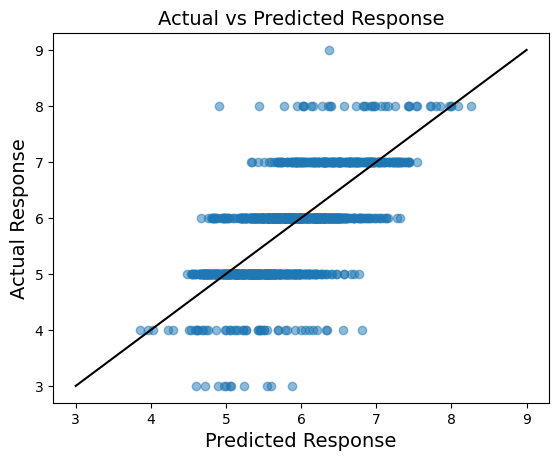

In [72]:
# making actual vs predicted plots
jitter_amount = 0.5
jittered_pred = pred_test + np.random.uniform(low=-jitter_amount, high=jitter_amount, size=len(pred_test))

x = np.linspace(3,9,1000)
plt.scatter(jittered_pred, y_test, alpha = 0.5)
plt.xlabel('Predicted Response', fontsize = 14)
plt.ylabel('Actual Response', fontsize = 14)
plt.title('Actual vs Predicted Response', fontsize = 14)
plt.plot(x, x, c = 'k');

### Stacking ensemble(s)

In [73]:
# linear regression model
linreg = LinearRegression().fit(train_df, y_train)
pred = linreg.predict(test_df)
print('RMSE for the linreg stacking ensemble =', np.sqrt(mean_squared_error(y_test, np.around(pred))))

RMSE for the linreg stacking ensemble = 0.6713934992009014


In [74]:
# lasso model
alphas = 10**np.linspace(0, -3, 300)*0.5
lassocv = LassoCV(alphas = alphas, cv = 5, max_iter = 100000)
lassocv.fit(train_df, y_train)
print('opt alpha = ', lassocv.alpha_)

lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(train_df, y_train)
pred = lasso.predict(test_df)
print('RMSE for the lasso stacking ensemble =', np.sqrt(mean_squared_error(y_test, np.around(pred))))

opt alpha =  0.0005
RMSE for the lasso stacking ensemble = 0.6598368096617643


In [75]:
# Mars model
mars_model = Earth(max_degree=1)
mars_model.fit(train_df, y_train)
pred = mars_model.predict(test_df)
print('RMSE for the mars stacking ensemble', np.sqrt(mean_squared_error(y_test, np.around(pred))))

RMSE for the mars stacking ensemble 0.6592536572635639


In [76]:
# random forest model
start_time = time.time()
param_grid = {'n_estimators': [100],
              'max_depth': [8, 10, 12, 14],
              'max_leaf_nodes':[100, 500, 1000],
              'max_features': [2, 4, 6, 8],
              'max_samples': [1000, 2000, 3000]}

cv = KFold(n_splits = 4, shuffle=True, random_state=1)
optimal_params = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=1),                                                       
                                    param_distributions = param_grid, n_iter = 100,
                                    scoring = 'neg_mean_squared_error',
                                    n_jobs=-1, verbose = 1, cv = cv)
optimal_params.fit(train_df, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation mse = ", -optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Optimal parameter values = {'n_estimators': 100, 'max_samples': 3000, 'max_leaf_nodes': 1000, 'max_features': 8, 'max_depth': 12}
Optimal cross validation mse =  0.0003126043406170428
Time taken =  0  minutes


In [77]:
rf_model = RandomForestRegressor(n_estimators = 100, max_samples = 3000, 
                                 max_leaf_nodes = 1000, max_features = 8,
                                 verbose = False, max_depth = 12,
                                 n_jobs= -1).fit(train_df, y_train)

print('Test RMSE', np.sqrt(mean_squared_error(y_test, np.around(rf_model.predict(test_df)))))

Test RMSE 0.6492599337233598


In [78]:
# xgboost model
start_time = time.time()
param_grid = {'max_depth': [3, 4, 5, 6],
              'learning_rate': [0.008, 0.01, 0.025, 0.05],
              'reg_lambda':[0, 1, 5],
              'n_estimators':[500, 600, 800, 1000],
              'gamma': [0, 3, 5, 10],
              'subsample': [0.5, 0.75, 1.0],
              'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits = 4, shuffle = True, random_state=1)
optimal_params = RandomizedSearchCV(estimator= XGBRegressor(random_state=1),                                                       
                                    param_distributions = param_grid, n_iter = 100,
                                    scoring = 'neg_mean_squared_error',
                                    n_jobs=-1, verbose = 1, cv = cv)
optimal_params.fit(train_df,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation mse = ", -optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.008, 'gamma': 0, 'colsample_bytree': 1.0}
Optimal cross validation mse =  3.4230875375944506e-06
Time taken =  1  minutes


In [79]:
xgb_model = XGBRegressor(subsample = 0.75, reg_lambda = 0, n_estimators = 1000, 
                         max_depth = 6, learning_rate = 0.008, gamma = 0,
                         colsample_bytree = 1, random_state = 1).fit(train_df, y_train)
print('Test RMSE', np.sqrt(mean_squared_error(y_test, np.around(xgb_model.predict(test_df)))))

Test RMSE 0.6753916242846414


### Ensemble of ensembled models

In [93]:
# use a voting ensemble to ensemble the metalmodels
pred = (linreg.predict(test_df).flatten() + lasso.predict(test_df) 
        + rf_model.predict(test_df)+ mars_model.predict(test_df)
         + xgb_model.predict(test_df))/5
print('rmse for the voting ensemble model:', np.sqrt(mean_squared_error(y_test, np.around(pred))))

rmse for the voting ensemble model: 0.6610015710443334


In [94]:
# tuning thee rounding threshold
p = np.linspace(0, 1, 100)
rmses = []
for i in p:
  base = np.floor(pred)
  diff = pred - base
  # cast to a list
  new_pred = base + np.array([int(x == True) for x in (diff > i)])
  rmse = np.sqrt(mean_squared_error(y_test, np.around(new_pred)))
  rmses.append(rmse)

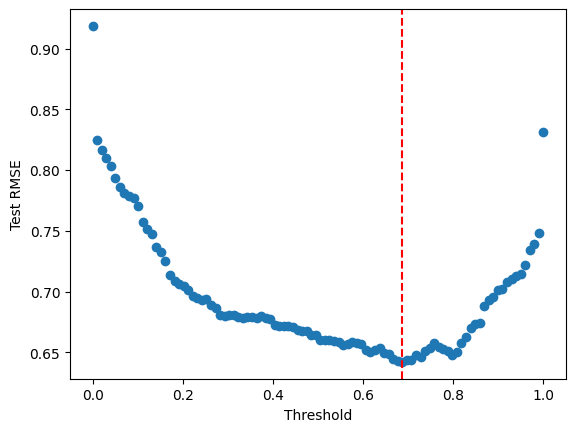

In [95]:
plt.scatter(p, rmses)
plt.axvline(p[np.array(rmses).argmin()], ls = '--', c = 'r')
plt.xlabel('Threshold')
plt.ylabel('Test RMSE');

In [99]:
# making new predictions based on the optimal threshold
opt_thresh = p[np.array(rmses).argmin()]
print('opt_thresh', opt_thresh)
new_pred = base + np.array([int(x == True) for x in (diff > opt_thresh)])
print('rmse for the voting ensemble model:', np.sqrt(mean_squared_error(y_test, np.around(new_pred))))

opt_thresh 0.686868686868687
rmse for the voting ensemble model: 0.6421119001448987


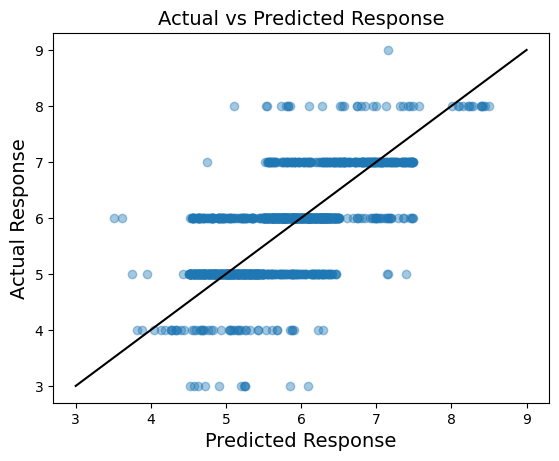

In [100]:
jitter_amount = 0.5
jittered_pred = new_pred + np.random.uniform(low=-jitter_amount, high=jitter_amount, size=len(new_pred))
x = np.linspace(3,9,1000)

plt.scatter(jittered_pred, y_test, alpha = 0.4)
plt.xlabel('Predicted Response', fontsize = 14)
plt.ylabel('Actual Response', fontsize = 14)
plt.title('Actual vs Predicted Response', fontsize = 14)
plt.plot(x, x, c = 'k');

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.